# Boundary Detection

---

Now we know how to find edge pixels in an image, we want to connect them to make boundaries in the image.

* **input**: a set of pixels we identified as edges
* **output**: one or multiple contours to define the image object 

---
## 1. Fitting Lines and Curves to Edges

**Idea:** Fit a mathematical model (straight line, polynomial, spline, or even parametric curve) to the set of edge pixels.

**Pros:**

* ✅ **Flexible**: Can model straight lines, curves, or smooth contours depending on the basis function chosen.
* ✅ **Compact representation**: Produces a simple formula describing the contour.
* ✅ **Efficient**: Computationally lighter than voting-based methods (like Hough).
* ✅ **Customizable**: You can control the degree of polynomial or use splines for local flexibility.

**Cons:**

* ❌ **Choice of model matters**: A low-degree polynomial may underfit; a high-degree may overfit to noise.
* ❌ **Global assumption**: Still assumes all input pixels belong to a single contour.
* ❌ **Sensitive to outliers**: Noisy or missing edge pixels can distort the fit.
* ❌ **Hard with multiple contours**: Needs segmentation first to separate different shapes.

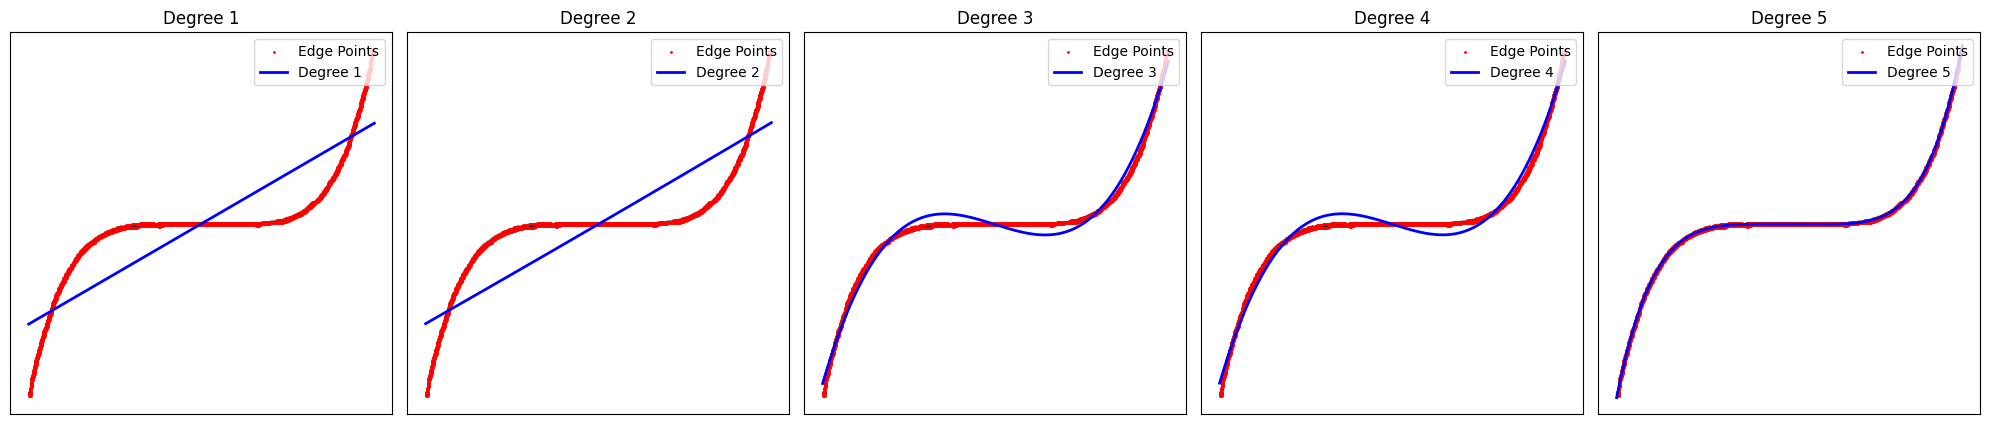

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fit_line_or_curve_subplot(edges, degrees, img):
    """
    Fit multiple polynomial degrees to the same edges and plot them in one row.
    """
    points = np.column_stack(np.where(edges > 0))
    y, x = points[:, 0], points[:, 1]

    num_degrees = len(degrees)
    fig, axes = plt.subplots(1, num_degrees, figsize=(4*num_degrees, 6))

    for i, degree in enumerate(degrees):
        coeffs = np.polyfit(x, y, degree)
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(x.min(), x.max(), 500)
        y_fit = poly(x_fit)

        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.scatter(x, y, s=1, color='red', label='Edge Points')
        ax.plot(x_fit, y_fit, color='blue', linewidth=2, label=f'Degree {degree}')
        ax.set_title(f'Degree {degree}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Load the image in grayscale
img = cv2.imread("../img/polynomial_curve.jpg", cv2.IMREAD_GRAYSCALE)

# Detect edges
edges = cv2.Canny(img, 50, 150)

# Plot degrees 1 to 5 in one row
fit_line_or_curve_subplot(edges, degrees=[1,2,3,4,5], img=img)


In this case, we were able to find the contour. But let's take a look at another example that not all edges belong to a single contour:

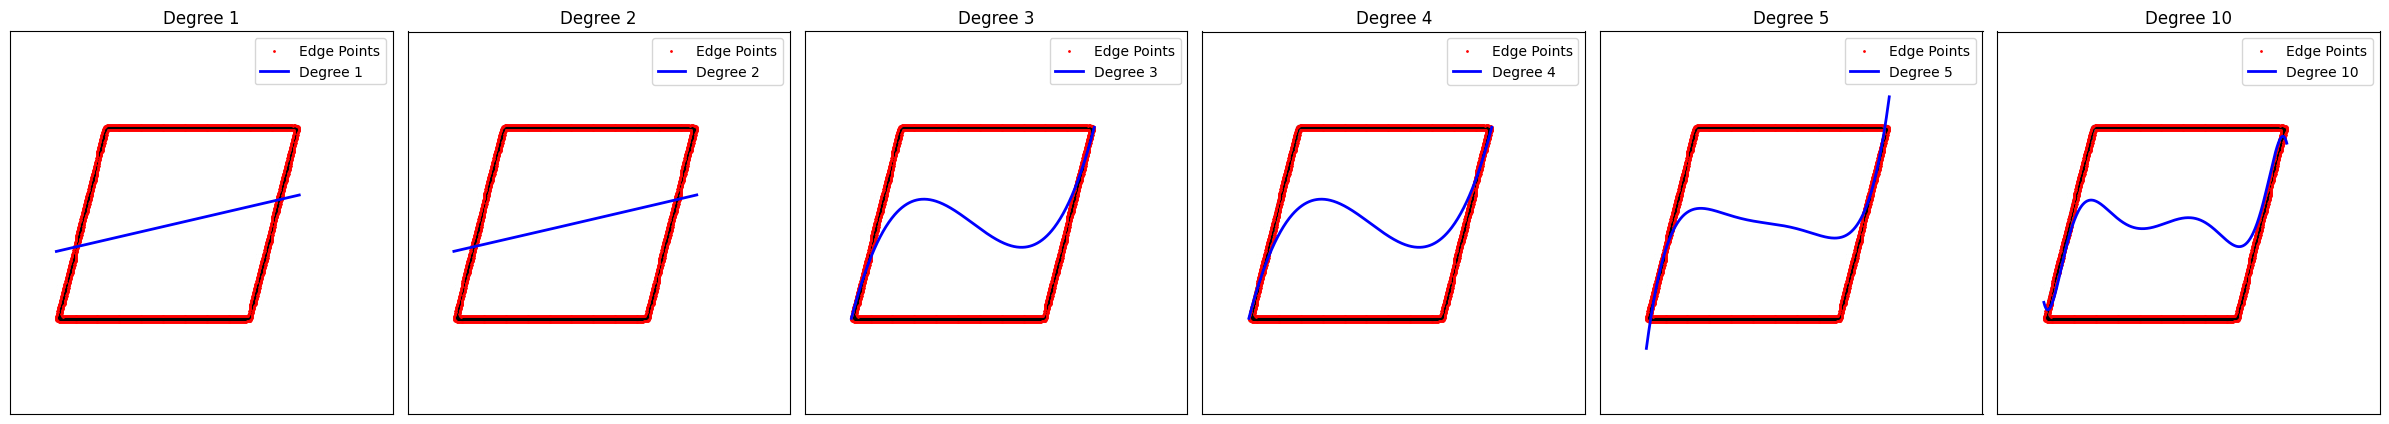

In [ ]:
img = cv2.imread("../img/parallelogram.jpg", cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, 50, 150)
fit_line_or_curve_subplot(edges, degrees=[1,2,3,4,5,10], img=img)

Although it is computationally lightweight and very flexible, the best-fit approach is generally not widely used in practice because it requires the edges to be grouped first. And that's why we have the hough transform!

---
## 2. Hough Transform

**Idea:** Votes for parameterized shapes (line, circle, ellipse, etc.) in parameter space.

**Pros:**

* ✅ **Robust to noise & gaps**: Can detect contours even with broken edges.
* ✅ **Multiple detections**: Naturally handles multiple lines or shapes at once.
* ✅ **Shape-specific**: With variants (e.g., circular/elliptical Hough), can find specific geometric contours.

**Cons:**

* ❌ **Less flexible for arbitrary shapes**: Limited to shapes you parameterize in advance.
* ❌ **More expensive**: Needs discretization of parameter space, which can get large for complex models.
* ❌ **Resolution trade-off**: Higher parameter resolution = more accuracy but slower and heavier.

---
### 2.1 Going from image space to parameter space

**Given:** Edge points $(x_i, y_i)$

**Task:** Find the line of best fit $y = mx + c$

Consider a point $(x_i, y_i)$, we know that $y_i = mx_i + c$ if this point is on the best fit line. In other words, $c = -mx_i + y_i$. Now, because $x_i$ and $y_i$ are known, we can treat $c$ and $m$ as variables. By doing this, we can go from image space ($x$ and $y$ are unknown) to the parameter space ($c$ and $m$ are unknown)

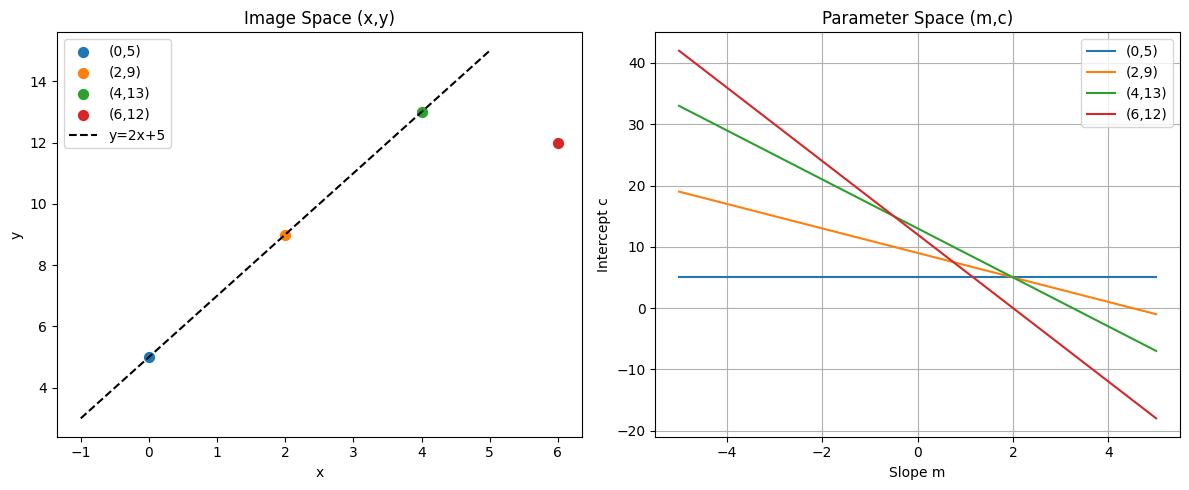

In [32]:
# The first three points on y = 2x + 5, last point is a noise
points = [(0, 5), (2, 9), (4, 13), (6, 12)]

# Range of slopes to consider
m_values = np.linspace(-5, 5, 200)

plt.figure(figsize=(12,5))

# ---- Image space ----
plt.subplot(1,2,1)
for (x, y) in points:
    plt.scatter(x, y, s=50, label=f"({x},{y})")
# Plot the actual line
x_line = np.linspace(-1, 5, 100)
y_line = 2*x_line + 5
plt.plot(x_line, y_line, 'k--', label="y=2x+5")
plt.title("Image Space (x,y)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# ---- Parameter space (m,c) ----
plt.subplot(1,2,2)
for (x, y) in points:
    c_values = y - m_values * x
    plt.plot(m_values, c_values, label=f"({x},{y})")

plt.title("Parameter Space (m,c)")
plt.xlabel("Slope m")
plt.ylabel("Intercept c")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In the example above, we have four points. Three of them are on the line $y = 2x + 5$ and the last point is a noise. 
* $(0, 5)$ ➡️ $5 = 0m + c$ ➡️ Potential Solutons in terms of m, c pairs: $[(0, 5), (1, 5), (2, 5), (3, 5) ...]$ ➡️ Blue Line
* $(2, 9)$ ➡️ $9 = 2m + c$ ➡️ Potential Solutons in terms of m, c pairs: $[(0, 9), (1, 7), (2, 5), (3, 3) ...]$ ➡️ Orange Line
* $(4, 13)$ ➡️ $13 = 4m + c$ ➡️ Potential Solutons in terms of m, c pairs: $[(0, 13), (1, 9), (2, 5), (3, 1) ...]$ ➡️ Green Line
* $(6, 12)$ ➡️ $12 = 6m + c$ ➡️ Potential Solutons in terms of m, c pairs: $[(0, 12), (1, 6), (2, 0), (3, -6) ...]$ ➡️ Red Line

You can now see the lines corresponding to the first three points cross at $(2, 5)$. To generalize which $(m, c)$ pair(s) we select, introducting voting through an accumulator array!

---
### 2.2 Voting 

* Quantize parameter space $(m, c)$
* Create an accumulator array $A(m, c)$ and initialize the values to be $0$
* For each edge pixel point $(x_i, y_i)$, $A(m, c) = A(m, c) + 1$ if $(m,c)$ lies on the line $c = -mx_i+y_i$
* Find the local maxima in $A(m, c)$ as a boundary line

For the above example, here is how the voting looks like if the increments of $m$ and $c$ is 1:

In [39]:
# Define slope (m) range and resolution
m_values = np.arange(-5, 6, 1)  # slopes -5 to 5, step 1

# Define intercept (c) range (depends on data)
c_min, c_max = -5, 20
c_values = np.arange(c_min, c_max+1, 1)

# Initialize accumulator
accumulator = np.zeros((len(c_values), len(m_values)), dtype=int)

# Voting
for (x, y) in points:
    for m_idx, m in enumerate(m_values):
        c = y - m * x
        if c_min <= c <= c_max:
            c_idx = int(c - c_min)  # shift to index
            accumulator[c_idx, m_idx] += 1

# Print accumulator in 2D grid format
print("Accumulator A(c,m):")
print(accumulator)

# Show where the maximum is
max_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
best_c = c_values[max_idx[0]]
best_m = m_values[max_idx[1]]
print(f"\nBest line: y = {best_m}x + {best_c}, votes={accumulator[max_idx]}")


Accumulator A(c,m):
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 3 1 1 1]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]

Best line: y = 2x + 5, votes=3


---
### 3.3 Better Parameterization

Now, if we take a step back, you can see that we pre-determined the range of $m$ to be between $-5$ and $5$, and the range of $c$ to be between $-5$ and $20$. Without this assumption, we basically have an infinity amount of values we need to consider. In a real situation, we have no idea what the range should be without doing testing and tuning, making the computation very heavy. To resolve this, instead of using $y = mx + c$, we will use 

$$x sin\theta - y cos\theta + \rho = 0$$

This solution guarantees:
* Orientation $\theta$ is finite ($ 0 \le \theta < \pi$)
* Distance $\rho$ is finite

Let's see what this parameterization looks like with the same example:

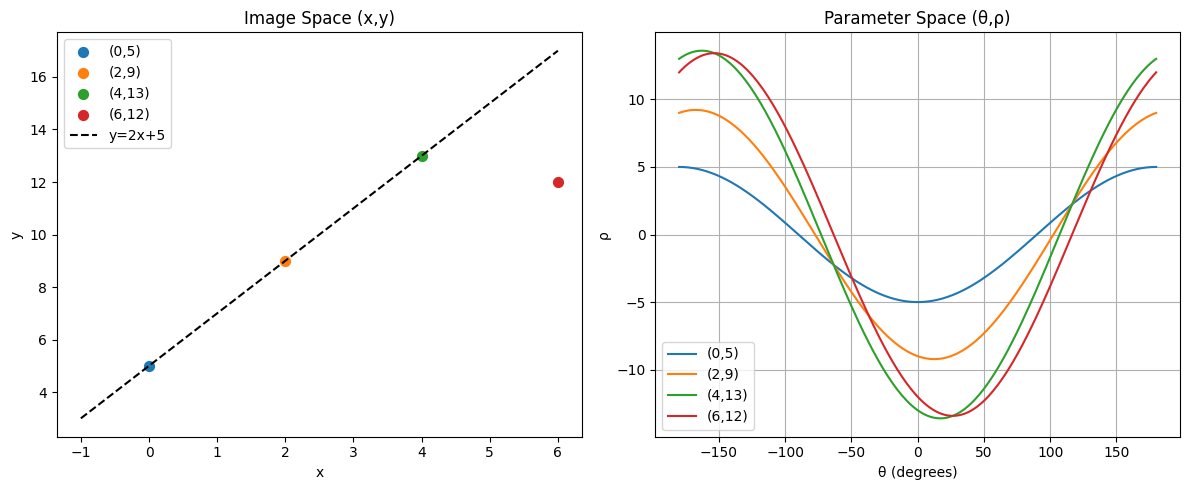

In [ ]:
# Range of theta to consider (-180° to 180°)
thetas = np.deg2rad(np.linspace(-180, 180, 200))

plt.figure(figsize=(12,5))

# ---- Image space ----
plt.subplot(1,2,1)
for (x, y) in points:
    plt.scatter(x, y, s=50, label=f"({x},{y})")
# Plot the actual line
x_line = np.linspace(-1, 6, 100)
y_line = 2*x_line + 5
plt.plot(x_line, y_line, 'k--', label="y=2x+5")
plt.title("Image Space (x,y)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# ---- Parameter space (θ,ρ) ----
plt.subplot(1,2,2)
for (x, y) in points:
    rho_values = -(x * np.sin(thetas) + y * np.cos(thetas))
    plt.plot(np.rad2deg(thetas), rho_values, label=f"({x},{y})")

plt.title("Parameter Space (θ,ρ)")
plt.xlabel("θ (degrees)")
plt.ylabel("ρ")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

we can see that in the parameter space above, we have two intersections instead one. That's because it is $\theta$ and $\theta + \pi$, which are essentially the same answers.

---

### 3.4 Put Everything Together! 

There are a few things we need to consider in our final version of our hough transform function:
- How big should the accumulator cell be?
    - To big then different lines will be merged
    - To small then noise causes lines to be missed
- How many contours are we trying to find?
    - Need a threshold to determine the number of peaks in the accumulator array

Becuase of these factors, we will have three parameters in our hough transform function:
- Theta Resolution: 
    - Angular resolution of the Hough transform in degrees.
    - Defines the step size when sampling θ values (range: -90° to 90°).
- Rho Resolution
    - Distance resolution of the Hough transform in pixels.
    - Defines the step size when sampling ρ values (range: -diag_len to +diag_len).
- Voting Threshold
    - Minimum number of votes (intersections in parameter space) required to consider a line as detected. 
    - Higher values make the detector stricter.

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def hough_transform(image_path, edge_thresh1=50, edge_thresh2=150, theta_res=1, rho_res=1, threshold=100):
    """
    Perform the Hough Transform to detect straight lines in an image.

    Parameters
    ----------
    image_path : str
        Path to the input image (should be a valid image file).
    
    edge_thresh1 : int, optional (default=50)
        First threshold for the Canny edge detector (lower bound).
    
    edge_thresh2 : int, optional (default=150)
        Second threshold for the Canny edge detector (upper bound).
        Edges with gradient values above this are considered strong.
    
    theta_res : float, optional (default=1)
        Angular resolution of the Hough transform in degrees.
        Defines the step size when sampling θ values (range: -90° to 90°).
    
    rho_res : float, optional (default=1)
        Distance resolution of the Hough transform in pixels.
        Defines the step size when sampling ρ values (range: -diag_len to +diag_len).
    
    threshold : int, optional (default=100)
        Minimum number of votes (intersections in parameter space) required
        to consider a line as detected. Higher values make the detector stricter.

    Returns
    -------
    accumulator : numpy.ndarray
        2D accumulator array of shape (num_rhos, num_thetas), where each cell 
        counts the votes for a particular (ρ, θ).
    
    output : numpy.ndarray
        The original image (in BGR color) with the detected lines drawn in red.

    Notes
    -----
    - The function first applies Canny edge detection to extract edge pixels.
    - For each edge point, it votes in Hough parameter space (ρ, θ).
    - Peaks in the accumulator array above the given `threshold` correspond to lines.
    - Detected lines are drawn back onto the original image.
    """
        
    # Load image and detect edges
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or cannot be loaded.")
    edges = cv2.Canny(img, edge_thresh1, edge_thresh2)

    # Image dimensions
    height, width = edges.shape
    diag_len = int(np.sqrt(height**2 + width**2))  # max possible rho

    # Discretize theta and rho
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))
    rhos = np.arange(-diag_len, diag_len, rho_res)

    # Accumulator
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

    # Edge points
    y_idxs, x_idxs = np.nonzero(edges)  # row, col

    # Voting
    for i in range(len(x_idxs)):
        x, y = x_idxs[i], y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int(round(x * np.cos(thetas[t_idx]) + y * np.sin(thetas[t_idx]))) + diag_len
            accumulator[rho, t_idx] += 1

    # Detect peaks in accumulator
    output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] > threshold:
                rho = rhos[rho_idx]
                theta = thetas[theta_idx]

                # Convert (rho, theta) back to line in image space
                a, b = np.cos(theta), np.sin(theta)
                x0, y0 = a * rho, b * rho
                x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
                x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
                cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Show detected lines
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines with Hough Transform")
    plt.axis("off")
    plt.show()


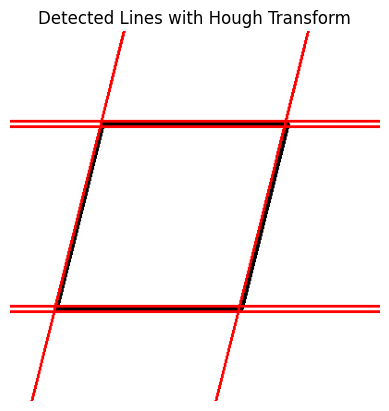

In [47]:
hough_transform("../img/parallelogram.jpg", threshold=110)